## Data description

In [1]:
! cat dataset\data_description.txt

cat: dataset\data_description.txt: No such file or directory


## Load dataset

In [2]:
import pandas as pd
from pathlib import Path
pd.options.mode.chained_assignment = None 
from sklearn.impute import SimpleImputer
import numpy as np

In [3]:
dataset_path = Path().absolute().parent / 'dataset'

In [4]:
train_data_path = dataset_path  / 'train.csv'

In [5]:
data = pd.read_csv(train_data_path, index_col=0)
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


## Cleaning data

In [6]:
null_columns = data.columns[data.isnull().sum() > 0]

In [7]:
def color_negative_red(val):
    color = 'red' if val > 0.03 else 'black'
    return 'color: %s' % color

In [8]:
null_values_df = pd.DataFrame(data[null_columns].isnull().sum().divide(len(data)), columns=['Null values'])

In [9]:
null_values_df.style.applymap(color_negative_red)

,Null values
LotFrontage,0.177397
Alley,0.937671
MasVnrType,0.005479
MasVnrArea,0.005479
BsmtQual,0.025342
BsmtCond,0.025342
BsmtExposure,0.026027
BsmtFinType1,0.025342
BsmtFinType2,0.026027
Electrical,0.000685


In [10]:
delete_columns = null_values_df[null_values_df['Null values']>0.03].index.values.tolist()
delete_columns

['LotFrontage',
 'Alley',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

## Exploring data types

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
data.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

## Preprocessing

In [13]:
def preprocess_data(data):
    
    delete_columns = ['LotFrontage', 'Alley', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                      'GarageQual', 'GarageCond', 'PoolQC', 'Fence','MiscFeature']
    
    data = data.drop(delete_columns, axis=1)
    
    object_columns = (data.dtypes == object)
    numerical_columns = (data.dtypes != object)
    
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    data.iloc[:,:] = imputer_cat.fit_transform(data)
    data.iloc[:,:] = imputer_cat.fit_transform(data)
    
    for column in data.columns[object_columns]:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
    return data

In [14]:
def skew_transform_data(data):
    numerical_columns = data.columns[(data.dtypes != object)]
    if 'SalePrice' in numerical_columns:
        numerical_columns = numerical_columns.drop('SalePrice')
    skew_limit = 10
    skew_vals = data[numerical_columns].skew()
    skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

    for col in skew_cols.index.tolist():
        data[col] = data[col].apply(np.log1p)
    
    return data

In [15]:
data = pd.read_csv(train_data_path, index_col=0)
data_preprocess = preprocess_data(data)
data_preprocess

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,8450,1,3,3,0,4,0,5,...,0,0,0,0,0,2,2008,8,4,208500
2,20,3,9600,1,3,3,0,2,0,24,...,0,0,0,0,0,5,2007,8,4,181500
3,60,3,11250,1,0,3,0,4,0,5,...,0,0,0,0,0,9,2008,8,4,223500
4,70,3,9550,1,0,3,0,0,0,6,...,272,0,0,0,0,2,2006,8,0,140000
5,60,3,14260,1,0,3,0,2,0,15,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,3,7917,1,3,3,0,4,0,8,...,0,0,0,0,0,8,2007,8,4,175000
1457,20,3,13175,1,3,3,0,4,0,14,...,0,0,0,0,0,2,2010,8,4,210000
1458,70,3,9042,1,3,3,0,4,0,6,...,0,0,0,0,2500,5,2010,8,4,266500


In [16]:
data_preprocess = skew_transform_data(data_preprocess)
data_preprocess

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,9.042040,0.693147,3,3,0.0,4,0,5,...,0,0.0,0,0.0,0.000000,2,2008,8,4,208500
2,20,3,9.169623,0.693147,3,3,0.0,2,0,24,...,0,0.0,0,0.0,0.000000,5,2007,8,4,181500
3,60,3,9.328212,0.693147,0,3,0.0,4,0,5,...,0,0.0,0,0.0,0.000000,9,2008,8,4,223500
4,70,3,9.164401,0.693147,0,3,0.0,0,0,6,...,272,0.0,0,0.0,0.000000,2,2006,8,0,140000
5,60,3,9.565284,0.693147,0,3,0.0,2,0,15,...,0,0.0,0,0.0,0.000000,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,3,8.976894,0.693147,3,3,0.0,4,0,8,...,0,0.0,0,0.0,0.000000,8,2007,8,4,175000
1457,20,3,9.486152,0.693147,3,3,0.0,4,0,14,...,0,0.0,0,0.0,0.000000,2,2010,8,4,210000
1458,70,3,9.109746,0.693147,3,3,0.0,4,0,6,...,0,0.0,0,0.0,7.824446,5,2010,8,4,266500


## Dividing into dependent and independt variable

In [17]:
from sklearn.model_selection import train_test_split

X = data_preprocess.drop(['SalePrice'],axis=1)
y = data_preprocess['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Regression test

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

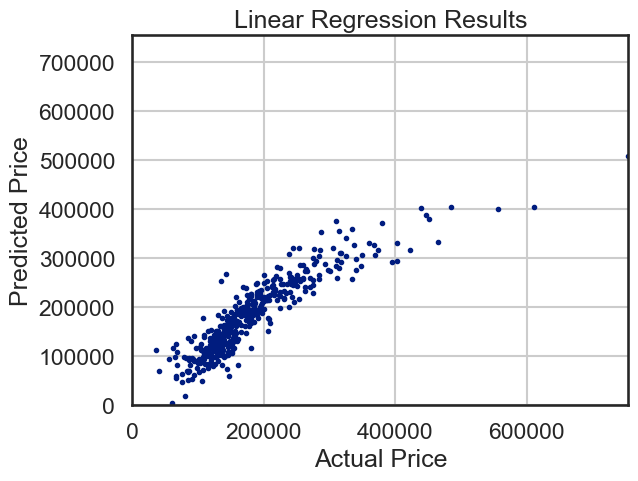

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

ax = plt.axes()

ax.plot(y_test, y_pred,  marker='o', ls='', ms=3.0)
lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');
ax.grid()

## Test data

In [20]:
test_data_path = Path().absolute().parent / 'dataset' / 'test.csv'
data_test = pd.read_csv(test_data_path, index_col = 0)

In [21]:
X_submission_test = preprocess_data(data_test)
X_submission_test = skew_transform_data(X_submission_test)

In [22]:
y_test_submission = lin_reg.predict(X_submission_test)

In [23]:
index = data_test.index

In [24]:
pd.DataFrame({'Id': index, 'SalePrice': y_test_submission}).to_csv('sample_submission_1.csv', index=False)